# auto regressive transformer https://fast-transformers.github.io/

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change. But blacklist large modules
%load_ext autoreload
%autoreload 2
%aimport -pandas
%aimport -torch
%aimport -numpy
%aimport -matplotlib
%aimport -dask
%aimport -functools
%aimport -tqdm
%aimport -pytorch_lightning
%matplotlib inline

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:

from neural_processes.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from neural_processes.plot import plot_from_loader

from neural_processes.dict_logger import DictLogger
from neural_processes.utils import PyTorchLightningPruningCallback
from neural_processes.train import main, objective, add_number, run_trial

from neural_processes.models.neural_process.lightning import PL_NP, PL_ANP, PL_ANPRNN

from neural_processes.models.transformer import PL_Transformer
from neural_processes.models.transformer_seq2seq import TransformerSeq2Seq_PL
from neural_processes.models.transformer_seq2seq_autor import TransformerSeq2SeqAutoR_PL

from neural_processes.models.lstm_seqseq import LSTMSeq2Seq_PL
from neural_processes.models.lstm_std import LSTM_PL_STD

In [5]:
# Params
device='cpu'
use_logy=False

In [6]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("autoregt.ipynb")

# Load kaggle smart meter data

In [7]:
df_train, df_val, df_test = get_smartmeter_df(
#     indir=Path('./data/smart-meters-in-london'), 
#     use_logy=False, 
#     max_files=40
)

In [8]:
data_train = SmartMeterDataSet(
    df_train, 100, 200)
b = data_train[10]
b = collate_fns(110, 220, sample=True)([b])
[bb.shape for bb in b]

[torch.Size([1, 106, 17]),
 torch.Size([1, 106, 1]),
 torch.Size([1, 188, 17]),
 torch.Size([1, 188, 1])]

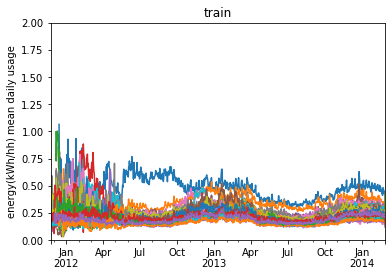

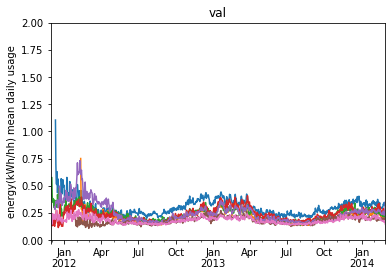

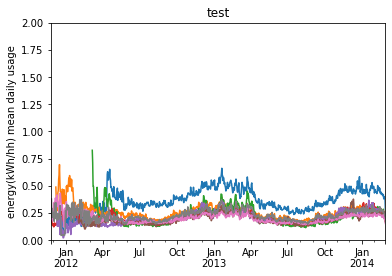

In [9]:
plt.figure()
for name,g in df_train.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('train')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_val.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('val')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_test.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('test')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

In [10]:
# df_train[['energy(kWh/hh)']].resample('30T').mean().plot(title='train', ylim=[0,3])
# df_val[['energy(kWh/hh)']].resample('30T').mean().plot(title='val', ylim=[0,3])
# df_test[['energy(kWh/hh)']].resample('30T').mean().plot(title='test', ylim=[0,3])

# MODEL (move to src)

In [11]:
import fast_transformers
from fast_transformers.builders import TransformerEncoderBuilder
# hidden=16
# n_heads=4
# encoder = fast_transformers.builders.TransformerEncoderBuilder.from_kwargs(
#     attention_type="causal-linear", # One of {'full', 'linear', 'causal-linear', 'clustered', 'improved-clustered', 'improved-causal', 'reformer', 'exact-topk'}.
#     n_layers=6,
#     n_heads=n_heads,
#     feed_forward_dimensions=hidden*4,
#     query_dimensions=hidden//n_heads,
#     value_dimensions=hidden//n_heads,
#     activation="gelu"
# ).get()
# x = torch.rand((10, 100, 16))
# # print(encoder)

# N = x.shape[1]
# mask = fast_transformers.masking.TriangularCausalMask(N, device=device)
# encoder(x, attn_mask=mask)
# # encoder.forward?

In [12]:
# import fast_transformers
# hidden=16
# n_heads=4
# encoder = fast_transformers.builders.RecurrentEncoderBuilder.from_kwargs(
#     attention_type="causal-linear",
#     n_layers=6,
#     n_heads=n_heads,
#     feed_forward_dimensions=hidden*4,
#     query_dimensions=hidden//n_heads,
#     value_dimensions=hidden//n_heads,
#     activation="gelu"
# ).get()
# x = torch.rand((10, 16))
# # print(encoder)

# N = x.shape[1]
# # mask = fast_transformers.masking.TriangularCausalMask(N, device=device)
# # encoder(x, attn_mask=mask)
# encoder(x)
# # encoder.forward?

In [13]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from test_tube import Experiment, HyperOptArgumentParser
from neural_processes.data.smart_meter import (
    collate_fns,
    SmartMeterDataSet,
    get_smartmeter_df,
)
import torchvision.transforms as transforms
from neural_processes.plot import plot_from_loader_to_tensor, plot_from_loader
from argparse import ArgumentParser
import json
import pytorch_lightning as pl
import math
from matplotlib import pyplot as plt
import torch
import io
import PIL
import optuna
from torchvision.transforms import ToTensor

from neural_processes.data.smart_meter import get_smartmeter_df
from neural_processes.modules import BatchNormSequence, LSTMBlock, NPBlockRelu2d

from neural_processes.utils import ObjectDict
from neural_processes.lightning import PL_Seq2Seq
from neural_processes.logger import logger
from neural_processes.utils import hparams_power


class TransformerSeq2SeqAutoRNet(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        hparams = hparams_power(hparams)
        self.hparams = hparams
        self._min_std = hparams.min_std

        hidden_out_size = self.hparams.hidden_out_size
        y_size = self.hparams.input_size - self.hparams.input_size_decoder
        x_size = self.hparams.input_size_decoder

        # Sometimes input normalisation can be important, an initial batch norm is a nice way to ensure this https://stackoverflow.com/a/46772183/221742
        self.x_norm = BatchNormSequence(x_size, affine=False)
        self.y_norm = BatchNormSequence(y_size, affine=False)

        # TODO embedd both X's the same
        if self.hparams.get('use_lstm', False):            
            self.x_emb = LSTMBlock(x_size, x_size)
            self.y_emb = LSTMBlock(y_size, y_size)
        
        n_heads = self.hparams.nhead
        self.enc_emb = nn.Linear(self.hparams.input_size, hidden_out_size*n_heads)
#         print(-1, self.hparams.input_size, hidden_out_size)
        self.dec_emb = nn.Linear(self.hparams.input_size_decoder, hidden_out_size*n_heads)
        
        
        self.encoder = fast_transformers.builders.TransformerEncoderBuilder.from_kwargs(
            attention_type="full",
            n_layers=self.hparams.nlayers,
            n_heads=n_heads,
            feed_forward_dimensions=hidden_out_size*4,
            query_dimensions=hidden_out_size,
            value_dimensions=hidden_out_size,
            activation="gelu",
            attention_dropout=self.hparams.attention_dropout,
            dropout=self.hparams.dropout,
        ).get()
        
        hidden_out_size *= 2
        self.decoder = fast_transformers.builders.TransformerEncoderBuilder.from_kwargs(
            attention_type="improved-causal",
            n_layers=self.hparams.nlayers,
            n_heads=n_heads,
            feed_forward_dimensions=hidden_out_size*4,
            query_dimensions=hidden_out_size,
            value_dimensions=hidden_out_size,
            activation="gelu",
            attention_dropout=self.hparams.attention_dropout,
            dropout=self.hparams.dropout,
        ).get()
        self.mean = NPBlockRelu2d(hidden_out_size*n_heads, self.hparams.output_size)
        self.std = NPBlockRelu2d(hidden_out_size*n_heads, self.hparams.output_size)

    def forward(self, context_x, context_y, target_x, target_y=None, mask_context=True, mask_target=True):
        device = next(self.parameters()).device

        # Norm
        context_x = self.x_norm(context_x)
        target_x = self.x_norm(target_x)
        context_y = self.y_norm(context_y)

        # LSTM
        if self.hparams.get('use_lstm', False):  
            context_x = self.x_emb(context_x)
            target_x = self.x_emb(target_x)
            # Size([B, C, X]) -> Size([B, C, X])
            context_y = self.y_emb(context_y)
            # Size([B, T, Y]) -> Size([B, T, Y])

        # Embed
        x = torch.cat([context_x, context_y], -1)
        x = self.enc_emb(x)
        # Size([B, C, X]) -> Size([B, C, hidden_dim])
        target_x = self.dec_emb(target_x)
        # Size([B, C, T]) -> Size([B, C, hidden_dim])
        
        # requires  (B, C, hidden_dim)
        memory = self.encoder(x)

        # In transformers the memory and target_x need to be the same length. Lets use a permutation invariant agg on the context
        # Then expand it, so it's available as we decode, conditional on target_x
        # (C, B, emb_dim) -> (B, emb_dim) -> (T, B, emb_dim)
        # In transformers the memory and target_x need to be the same length. Lets use a permutation invariant agg on the context
        # Then expand it, so it's available as we decode, conditional on target_x
        memory = memory_last = memory[:, -1:, :].expand_as(target_x)
        x2 = torch.cat([target_x, memory], -1)
        N = x2.shape[1]
        mask = fast_transformers.masking.TriangularCausalMask(N, device=device)
        outputs = self.decoder(x2, attn_mask=mask)
        
        # Size([B, T, emb_dim])
        mean = self.mean(outputs)
        log_sigma = self.std(outputs)
        sigma = self._min_std + (1 - self._min_std) * F.softplus(log_sigma)
        y_dist = torch.distributions.Normal(mean, sigma)

        # Loss
        loss_mse = loss_p = loss_p_weighted = None
        if target_y is not None:
            loss_mse = F.mse_loss(mean, target_y, reduction="none")
            loss_p = -y_dist.log_prob(target_y).mean(-1)

            # Weight loss nearer to prediction time?
            weight = (torch.arange(loss_p.shape[1]) + 1).float().to(device)[None, :]
            loss_p_weighted = loss_p / torch.sqrt(weight)  # We want to weight nearer stuff more

        y_pred = y_dist.rsample if self.training else y_dist.loc
        return (
            y_pred,
            dict(loss=loss_p.mean(), loss_p=loss_p.mean(), loss_mse=loss_mse.mean(), loss_p_weighted=loss_p_weighted.mean()),
            dict(log_sigma=log_sigma, y_dist=y_dist),
        )


class TransformerSeq2SeqAutoR_PL(PL_Seq2Seq):
    def __init__(self, hparams, MODEL_CLS=TransformerSeq2SeqAutoRNet, **kwargs):
        super().__init__(hparams, MODEL_CLS=MODEL_CLS, **kwargs)

    DEFAULT_ARGS = {
        "attention_dropout": 0.2,
        "dropout": 0.2,
        "hidden_out_size_power": 4,
        "hidden_size_power": 5,
        "learning_rate": 2e-3,
        "nhead_power": 3,
        "nlayers": 6,
        "use_lstm": False
    }

    @staticmethod
    def add_suggest(trial: optuna.Trial, user_attrs={}):
        """
        Add hyperparam ranges to an optuna trial and typical user attrs.
        
        Usage:
            trial = optuna.trial.FixedTrial(
                params={         
                    'hidden_size': 128,
                }
            )
            trial = add_suggest(trial)
            trainer = pl.Trainer()
            model = LSTM_PL(dict(**trial.params, **trial.user_attrs), dataset_train,
                            dataset_test, cache_base_path, norm)
            trainer.fit(model)
        """
        trial.suggest_loguniform("learning_rate", 1e-6, 1e-2)
        trial.suggest_uniform("attention_dropout", 0, 0.75)
        trial.suggest_uniform("dropout", 0, 0.75)
        # we must have nhead<==hidden_size
        # so           nhead_power.max()<==hidden_size_power.min()
        trial.suggest_discrete_uniform("hidden_size_power", 4, 10, 1)
        trial.suggest_discrete_uniform("hidden_out_size_power", 4, 9, 1)
        trial.suggest_discrete_uniform("nhead_power", 1, 4, 1)
        trial.suggest_int("nlayers", 1, 12)
        trial.suggest_categorical("use_lstm", [False, True])

        user_attrs_default = {
            "batch_size": 16,
            "grad_clip": 40,
            "max_nb_epochs": 200,
            "num_workers": 4,
            "num_extra_target": 24 * 4,
            "vis_i": "670",
            "num_context": 24 * 4,
            "input_size": 18,
            "input_size_decoder": 17,
            "output_size": 1,
            "patience": 3,
            'min_std': 0.005,
        }
        [trial.set_user_attr(k, v) for k, v in user_attrs_default.items()]
        [trial.set_user_attr(k, v) for k, v in user_attrs.items()]
        return trial


# Experiments

In [14]:
# Summarize results


def summarize_results(results):
    result_dfs = []
    for k in results:
        v = results[k]
        df = pd.DataFrame(v).mean()
        df.name = k+'_mean'
        df['n'] = len(v)
        result_dfs.append(df)

#         df = pd.DataFrame(v).std()
#         df.name = k+'_std'
#         df['n'] = len(v)
#         result_dfs.append(df)

    if len(result_dfs)==0:
        return None
    result_df = pd.concat(result_dfs, 1).T
    
    return result_df.sort_values('agg_test_score').T

In [15]:
default_user_attrs = {
    'x_dim': 17,
    'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 48 * 7,
    'num_extra_target': 48 * 7,
    'max_nb_epochs': 20,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 24,
    'patience': 2,
    'max_epoch_steps': 32 * 600,
}
N = 3

experiments = [
    dict(
        name="TransformerSeq2SeqAutoR_PL",
        PL_MODEL_CLS=TransformerSeq2SeqAutoR_PL,
    ),
]
number = -1
results = collections.defaultdict(list)

INFO:predict_heading2:now run `tensorboard --logdir lightning_logs`


EarlyStopping mode auto is unknown, fallback to auto mode.


INFO:lightning:EarlyStopping mode auto is unknown, fallback to auto mode.


EarlyStopping mode set to min for monitoring val_loss.


INFO:lightning:EarlyStopping mode set to min for monitoring val_loss.


GPU available: True, used: False


INFO:lightning:GPU available: True, used: False


TPU available: False, using: 0 TPU cores


INFO:lightning:TPU available: False, using: 0 TPU cores
INFO:predict_heading2:trial number=-1000 name=TransformerSeq2SeqAutoR_PL, trial=<optuna.trial.FixedTrial object at 0x7f506c2916a0> params={'learning_rate': 0.002, 'attention_dropout': 0.2, 'dropout': 0.2, 'hidden_size_power': 5, 'hidden_out_size_power': 4, 'nhead_power': 3, 'nlayers': 6, 'use_lstm': False} attrs={'batch_size': 24, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 3, 'num_extra_target': 336, 'vis_i': '670', 'num_context': 336, 'input_size': 18, 'input_size_decoder': 17, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'max_epoch_steps': 19200}



  | Name   | Type                       | Params
------------------------------------------------------
0 | _model | TransformerSeq2SeqAutoRNet | 2 M   


INFO:lightning:
  | Name   | Type                       | Params
------------------------------------------------------
0 | _model | TransformerSeq2SeqAutoRNet | 2 M   


2 torch.Size([24, 336, 256]) torch.Size([336, 336])
TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (attention): AttentionLayer(
        (inner_attention): ImprovedClusteredCausalAttention(
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (query_projection): Linear(in_features=256, out_features=256, bias=True)
        (key_projection): Linear(in_features=256, out_features=256, bias=True)
        (value_projection): Linear(in_features=256, out_features=256, bias=True)
        (out_projection): Linear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (attention): A

)
INFO:predict_heading2:val step=0, outputs={'val_loss_p_weighted': tensor(0.1246), 'val_loss_p': tensor(1.1732), 'val_loss_mse': tensor(0.2488), 'val_loss': tensor(1.1732)}
2 torch.Size([1, 336, 256]) torch.Size([336, 336])
TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (attention): AttentionLayer(
        (inner_attention): ImprovedClusteredCausalAttention(
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (query_projection): Linear(in_features=256, out_features=256, bias=True)
        (key_projection): Linear(in_features=256, out_features=256, bias=True)
        (value_projection): Linear(in_features=256, out_features=256, bias=True)
        (out_projection): Linear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
   

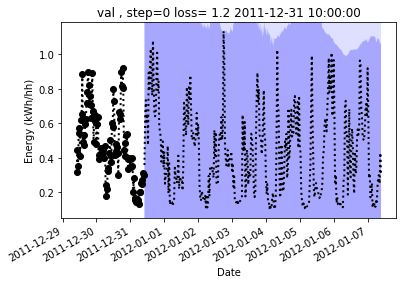

2 torch.Size([24, 166, 256]) torch.Size([166, 166])
TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (attention): AttentionLayer(
        (inner_attention): ImprovedClusteredCausalAttention(
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (query_projection): Linear(in_features=256, out_features=256, bias=True)
        (key_projection): Linear(in_features=256, out_features=256, bias=True)
        (value_projection): Linear(in_features=256, out_features=256, bias=True)
        (out_projection): Linear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (attention): A

)


In [ ]:
# TEST
i=0
exp= dict(
        name="TransformerSeq2SeqAutoR_PL",
        PL_MODEL_CLS=TransformerSeq2SeqAutoR_PL,
    )
trial, trainer, model = run_trial(
    user_attrs = default_user_attrs,
    number=number*i*100-1000,
    **exp)

In [ ]:
for i in range(N):
    for exp in experiments:
        print(i, exp)
        trial, trainer, model = run_trial(
            user_attrs = default_user_attrs,
            number=number*i*100-1000,
            **exp)

        name = trainer.logger.name
        r=trainer.logger.metrics[-1]
        if 'agg_test_score' in r:
            results[name].append(r)

            display(summarize_results(results))

In [ ]:
display(summarize_results(results))

In [ ]:
result_dfs = []
for k in results:
    v = results[k]
    df = pd.DataFrame(v).mean()
    df = pd.concat([pd.DataFrame(v).mean().rename(lambda x:'mean_' + x),
    pd.DataFrame(v).std().rename(lambda x:'std_' + x),
    pd.DataFrame(v).min().rename(lambda x:'min_' + x)])

    df.name = k
    df['n'] = len(v)
    result_dfs.append(df)

#         df = pd.DataFrame(v).std()
#         df.name = k+'_std'
#         df['n'] = len(v)
#         result_dfs.append(df)


result_df = pd.concat(result_dfs, 1).T
result_df.sort_values('min_agg_test_score').T

# Manual exp

In [ ]:
number=None

# Hyperparam

In [ ]:
from neural_processes.train import objective
import argparse 

In [ ]:
optuna_path = Path('./optuna_result2')
optuna_path.mkdir(exist_ok=True)

In [ ]:
for PL_MODEL_CLS in [TransformerSeq2Seq_PL, PL_ANPRNN]:
    name = str(PL_MODEL_CLS.__name__)
    func = functools.partial(objective,
                             PL_MODEL_CLS=PL_MODEL_CLS,
                             name=name,
                             user_attrs=default_user_attrs)

    parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
    parser.add_argument(
        '--pruning',
        '-p',
        action='store_true',
        help='Activate the pruning feature. `MedianPruner` stops unpromising '
        'trials at the early stages of training.')
    args = parser.parse_args(['-p'])

    pruner = optuna.pruners.MedianPruner(
        n_warmup_steps=1,
        n_startup_trials=6) if args.pruning else optuna.pruners.NopPruner()
    pruner = optuna.pruners.PercentilePruner(75.0)

    study = optuna.create_study(direction='minimize',
                                pruner=pruner,
                                storage=f'sqlite:///{optuna_path}/{name}.db',
                                study_name=name,
                                load_if_exists=True)

#     1/0
    study.optimize(func=func,
                   n_trials=200,
                   timeout=pd.Timedelta('0.5d').total_seconds())

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    # shutil.rmtree(MODEL_DIR)

    df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
    print(df.sort_values('value'))

In [ ]:
PL_MODEL_CLS

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')